In [6]:

import numpy as np
import pandas as pd

from collections import defaultdict
import re

import sys
import os
import tensorflow as tf


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [12]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix, classification_report,precision_recall_curve
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [7]:
df =pd.read_csv('./input/dataset.csv')
df.head()

,article,y
0,peripher neuropathi wikipedia free encyclopedi...,1
1,colorado tick fever wikipedia free encyclopedi...,1
2,rosselli gulienetti syndrom wikipedia free enc...,1
3,johanson blizzard syndrom wikipedia free encyc...,1
4,digeorg syndrom wikipedia free encyclopedia di...,1


In [34]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1

In [25]:
df["article"] = df["article"].astype(str)
X = df['article'].tolist()


In [13]:
y = df['y']
y = to_categorical(y)

In [50]:
df['y'].head()

0    1
1    1
2    1
3    1
4    1
Name: y, dtype: int64

In [51]:
y[0:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [32]:
df["word_count"] = df["article"].apply(lambda x: len(str(x).split(" ")))

In [33]:
df.describe()

,y,word_count
count,13695.000000,13695.000000
mean,0.269806,358.812267
std,0.443875,647.346822
min,0.000000,1.000000
25%,0.000000,41.000000
50%,0.000000,126.000000
75%,1.000000,376.000000
max,1.000000,18163.000000


In [27]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 130371


In [35]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [36]:
print('Shape of Data Tensor:', data.shape)

Shape of Data Tensor: (13695, 1000)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(data,y, test_size=0.10, random_state=42, stratify=np.argmax(y, axis=1))
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.05, random_state=42, stratify=np.argmax(y_train, axis=1))


In [53]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_test.shape)



(11708, 1000) (11708, 2)
(1370, 1000) (1370, 2)
(617, 1000) (1370, 2)


(array([8549.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3159.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

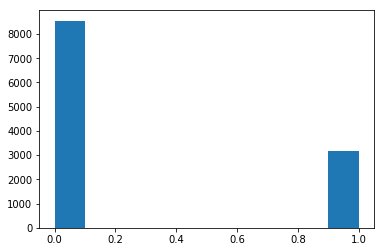

In [54]:
plt.hist(np.argmax(y_train, axis=1))

In [39]:
def cnn_trainable_embedding_model():
    embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool3)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("Simplified convolutional neural network")
    model.summary()
    return model

In [40]:
model  = cnn_trainable_embedding_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Simplified convolutional neural network
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         13037200  
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None,

In [41]:
cp=ModelCheckpoint('model_cnn_v1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [57]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=5, batch_size=32,callbacks=[cp])

Train on 11708 samples, validate on 617 samples
Epoch 1/5
11680/11708 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9849
Epoch 00001: val_acc improved from -inf to 0.99190, saving model to model_cnn_v1.hdf5
11708/11708 [==============================] - 157s 13ms/sample - loss: 0.0534 - acc: 0.9850 - val_loss: 0.0339 - val_acc: 0.9919
Epoch 2/5
11680/11708 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9942
Epoch 00002: val_acc did not improve from 0.99190
11708/11708 [==============================] - 154s 13ms/sample - loss: 0.0246 - acc: 0.9942 - val_loss: 0.0495 - val_acc: 0.9870
Epoch 3/5
11680/11708 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9958
Epoch 00003: val_acc did not improve from 0.99190
11708/11708 [==============================] - 148s 13ms/sample - loss: 0.0183 - acc: 0.9957 - val_loss: 0.0663 - val_acc: 0.9806
Epoch 4/5
11680/11708 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9976


In [59]:
def predict(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

def evaluate(y_test, y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    print(f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [60]:
y_pred = predict(model, X_test)

In [61]:
evaluate(y_test, y_pred)

[[989  11]
 [  8 362]]
0.9744279946164199
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.97      0.98      0.97       370

    accuracy                           0.99      1370
   macro avg       0.98      0.98      0.98      1370
weighted avg       0.99      0.99      0.99      1370



In [72]:
# Since the best model is yielded in earier epochs lets load the best model and test the same
model.load_weights('./model_cnn_v1.hdf5')
y_pred = predict(model, X_test)
evaluate(y_test, y_pred)

[[991   9]
 [  4 366]]
0.9825503355704698
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1000
           1       0.98      0.99      0.98       370

    accuracy                           0.99      1370
   macro avg       0.99      0.99      0.99      1370
weighted avg       0.99      0.99      0.99      1370



In [88]:
def cnn_trainable_embedding_model_with_reg():
    embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool3)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("Simplified convolutional neural network")
    model.summary()
    return model

In [62]:
from sklearn.utils import class_weight

In [89]:
model_v2  = cnn_trainable_embedding_model_with_reg()
cp_v2=ModelCheckpoint('model_cnn_v2.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 1000, 100)         13037200  
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D) 

In [90]:
history_v2 = model_v2.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=5, batch_size=32,
                  class_weight=class_weights,
                  callbacks=[cp_v2])

Train on 11708 samples, validate on 617 samples
Epoch 1/5
11680/11708 [============================>.] - ETA: 0s - loss: 0.1952 - acc: 0.9656
Epoch 00001: val_acc improved from -inf to 0.98379, saving model to model_cnn_v2.hdf5
11708/11708 [==============================] - 155s 13ms/sample - loss: 0.1948 - acc: 0.9657 - val_loss: 0.0716 - val_acc: 0.9838
Epoch 2/5
11680/11708 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9885
Epoch 00002: val_acc improved from 0.98379 to 0.98541, saving model to model_cnn_v2.hdf5
11708/11708 [==============================] - 147s 13ms/sample - loss: 0.0484 - acc: 0.9886 - val_loss: 0.0609 - val_acc: 0.9854
Epoch 3/5
11680/11708 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9910
Epoch 00003: val_acc did not improve from 0.98541
11708/11708 [==============================] - 147s 13ms/sample - loss: 0.0458 - acc: 0.9910 - val_loss: 0.0681 - val_acc: 0.9838
Epoch 4/5
11680/11708 [============================>.] 

In [92]:
y_pred = predict(model_v2, X_test)
evaluate(y_test, y_pred)

[[994   6]
 [  9 361]]
0.9796472184531886
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.98      0.98       370

    accuracy                           0.99      1370
   macro avg       0.99      0.98      0.99      1370
weighted avg       0.99      0.99      0.99      1370



In [91]:
# Let load the best model and test the same
model_v2.load_weights('./model_cnn_v2.hdf5')
y_pred = predict(model_v2, X_test)
evaluate(y_test, y_pred)

[[994   6]
 [  9 361]]
0.9796472184531886
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.98      0.98       370

    accuracy                           0.99      1370
   macro avg       0.99      0.98      0.99      1370
weighted avg       0.99      0.99      0.99      1370

